# Whole image quality control metric evaluation - Saturation

In this notebook, we will use the outputted QC metrics per image (every z-slice per channel) to start working on developing thresholds using z-score to flag images during CellProfiler processing.
We are loading in the results from the preliminary data (across three patients) to attempt to develop generalizable thresholds.
This data is 3D, so we are decide if it make sense to remove a whole organoid based on if one z-slice fails.

## Over-saturated image detection

For detecting poor quality images based on saturation, we use the feature `PercentMaximal`, where higher values means the image contains overly saturated pixels.
We know that this metric is on a scale from 0 to 100, where 100 means that all of the pixels in an image are at the highest pixel intensity based on the intensity distribution of that image.
We will process each channel independently but including all plates together.

We will use a method called `coSMicQC`, which takes a feature of interest and detect outliers based on z-scoring and how far from the mean that outliers will be.

## Import libraries

In [1]:
import pathlib
import pandas as pd
import cosmicqc
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Set paths and variables

In [2]:
# Set the threshold for identifying outliers with z-scoring for all metrics (# of standard deviations away from mean)
threshold_z = 2

# Directory for figures to be outputted
figure_dir = pathlib.Path("./qc_figures")
figure_dir.mkdir(exist_ok=True)

# Directory containing the QC results
qc_results_dir = pathlib.Path("./qc_results")

# Find all Image.csv files for all plates using glob
image_csv_paths = qc_results_dir.glob("*/Image.csv")

# Path to the template pipeline file to update with proper thresholds for flagging
pipeline_path = pathlib.Path("pipeline/template_flag_pipeline.cppipe")

## Load in QC results per plate and combine

In [3]:
# Define prefixes for columns to select
prefixes = (
    "Metadata",
    "FileName",
    "PathName",
    "ImageQuality_PercentMaximal",
)

# Load and concatenate the data for all plates
qc_dfs = []
for path in image_csv_paths:
    # Load only the required columns by filtering columns with specified prefixes
    plate_df = pd.read_csv(path, usecols=lambda col: col.startswith(prefixes))
    qc_dfs.append(plate_df)

# Concatenate all plate data into a single dataframe
concat_qc_df = pd.concat(qc_dfs, ignore_index=True)

print(concat_qc_df.shape)
concat_qc_df.head(2)

(9938, 23)


,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,ImageQuality_PercentMaximal_AGP,ImageQuality_PercentMaximal_Brightfield,ImageQuality_PercentMaximal_DNA,ImageQuality_PercentMaximal_ER,ImageQuality_PercentMaximal_Mito,...,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito
0,C10-1 (60X)_555_ZS000_FOV-1.tif,C10-1 (60X)_TRANS_ZS000_FOV-1.tif,C10-1 (60X)_405_ZS000_FOV-1.tif,C10-1 (60X)_488_ZS000_FOV-1.tif,C10-1 (60X)_640_ZS000_FOV-1.tif,0.000042,0.000127,0.000042,0.000253,0.000042,...,NF0018,0,1.0,C10,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
1,C10-1 (60X)_555_ZS001_FOV-1.tif,C10-1 (60X)_TRANS_ZS001_FOV-1.tif,C10-1 (60X)_405_ZS001_FOV-1.tif,C10-1 (60X)_488_ZS001_FOV-1.tif,C10-1 (60X)_640_ZS001_FOV-1.tif,0.000042,0.000042,0.000042,0.000042,0.000042,...,NF0018,0,1.0,C10,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...


## Detect over-saturation in DNA channel

In [4]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for blur in DNA channel
saturation_DNA_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_DNA": 8,
    },
)

pd.DataFrame(saturation_DNA_outliers).head()

Number of outliers: 30 (0.30%)
Outliers Range:
ImageQuality_PercentMaximal_DNA Min: 0.104849666253175
ImageQuality_PercentMaximal_DNA Max: 0.3177556686328616


,ImageQuality_PercentMaximal_DNA,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito
1601,0.105947,E2-1 (60X)_555_ZS001_FOV-1.tif,E2-1 (60X)_TRANS_ZS001_FOV-1.tif,E2-1 (60X)_405_ZS001_FOV-1.tif,E2-1 (60X)_488_ZS001_FOV-1.tif,E2-1 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,E2,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
2010,0.112318,E8-1 (60X)_555_ZS001_FOV-1.tif,E8-1 (60X)_TRANS_ZS001_FOV-1.tif,E8-1 (60X)_405_ZS001_FOV-1.tif,E8-1 (60X)_488_ZS001_FOV-1.tif,E8-1 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,E8,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
3363,0.104850,G4-4 (60X)_555_ZS000_FOV-1.tif,G4-4 (60X)_TRANS_ZS000_FOV-1.tif,G4-4 (60X)_405_ZS000_FOV-1.tif,G4-4 (60X)_488_ZS000_FOV-1.tif,G4-4 (60X)_640_ZS000_FOV-1.tif,NaN,NaN,0,NF0018,0,4.0,G4,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
3364,0.134174,G4-4 (60X)_555_ZS001_FOV-1.tif,G4-4 (60X)_TRANS_ZS001_FOV-1.tif,G4-4 (60X)_405_ZS001_FOV-1.tif,G4-4 (60X)_488_ZS001_FOV-1.tif,G4-4 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0018,0,4.0,G4,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
3365,0.153794,G4-4 (60X)_555_ZS002_FOV-1.tif,G4-4 (60X)_TRANS_ZS002_FOV-1.tif,G4-4 (60X)_405_ZS002_FOV-1.tif,G4-4 (60X)_488_ZS002_FOV-1.tif,G4-4 (60X)_640_ZS002_FOV-1.tif,NaN,NaN,0,NF0018,0,4.0,G4,ZS002,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...


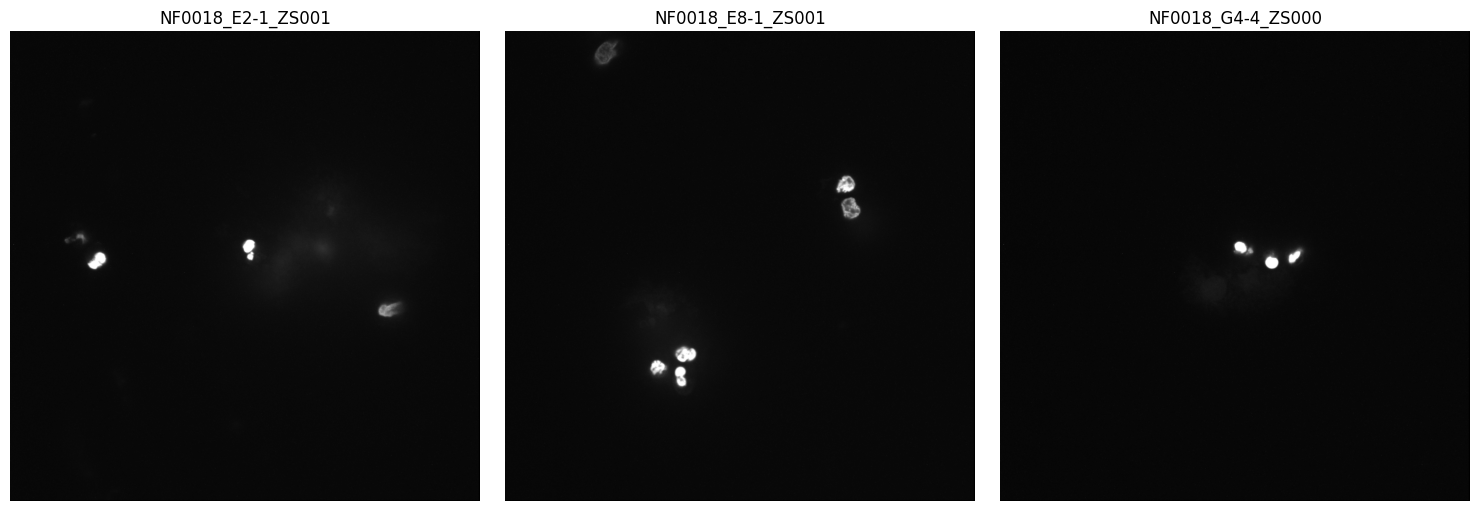

In [5]:
# Combine PathName and FileName columns to construct full paths for DNA
saturation_DNA_outliers["Full_Path_DNA"] = (
    saturation_DNA_outliers["PathName_DNA"] + "/" + saturation_DNA_outliers["FileName_DNA"]
)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the first 3 rows of the blur_DNA_outliers dataframe and display each image
for idx, row in enumerate(saturation_DNA_outliers.itertuples(), start=1):
    if idx > 3:  # Only display the first 3 images
        break
    image_path = row.Full_Path_DNA
    # Format the metadata title based on your desired structure
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)  # Set the formatted metadata as the title
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
# Read the content of the pipeline file
with open(pipeline_path, 'r') as file:
    pipeline_content = file.read()

# Find the minimum value of the ImageQuality_PercentMaximal_DNA from the outliers dataframe
min_value_dna = saturation_DNA_outliers['ImageQuality_PercentMaximal_DNA'].min()

# Define the regex pattern to find the relevant section and update the Maximum value with min value (anything above this value will be flagged)
pattern = re.compile(
    r'(Which measurement\?:ImageQuality_PercentMaximal_DNA.*?Maximum value:\s*)-?\d+(\.\d+)?',
    re.DOTALL
)

# Update the pipeline content
updated_pipeline_content = pattern.sub(lambda m: f"{m.group(1)}{min_value_dna}", pipeline_content)

# Write the updated content back to the file
with open(pipeline_path, 'w') as file:
    file.write(updated_pipeline_content)

print(f"Updated the Maximum value for ImageQuality_PercentMaximal_DNA to {min_value_dna} in the template pipeline file.")

Updated the Maximum value for ImageQuality_PercentMaximal_DNA to 0.104849666253175 in the template pipeline file.


## Detect over-saturation in Mito channel

In [7]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for Mito channel
saturation_Mito_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_Mito": 6,
    },
)

pd.DataFrame(saturation_Mito_outliers)

saturation_Mito_outliers = saturation_Mito_outliers.sort_values(
    by="ImageQuality_PercentMaximal_Mito", ascending=True
)

saturation_Mito_outliers.head()

Number of outliers: 34 (0.34%)
Outliers Range:
ImageQuality_PercentMaximal_Mito Min: 0.0897023704041247
ImageQuality_PercentMaximal_Mito Max: 0.6482958237344202


,ImageQuality_PercentMaximal_Mito,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito
3641,0.089702,G8-2 (60X)_555_ZS000_FOV-1.tif,G8-2 (60X)_TRANS_ZS000_FOV-1.tif,G8-2 (60X)_405_ZS000_FOV-1.tif,G8-2 (60X)_488_ZS000_FOV-1.tif,G8-2 (60X)_640_ZS000_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,G8,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
2479,0.090040,F2-3 (60X)_555_ZS001_FOV-1.tif,F2-3 (60X)_TRANS_ZS001_FOV-1.tif,F2-3 (60X)_405_ZS001_FOV-1.tif,F2-3 (60X)_488_ZS001_FOV-1.tif,F2-3 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0018,0,3.0,F2,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
2755,0.092276,F6-1 (60X)_555_ZS001_FOV-1.tif,F6-1 (60X)_TRANS_ZS001_FOV-1.tif,F6-1 (60X)_405_ZS001_FOV-1.tif,F6-1 (60X)_488_ZS001_FOV-1.tif,F6-1 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,F6,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
8010,0.094551,E2-2_555_ZS001_FOV-1.tif,E2-2_TRANS_ZS001_FOV-1.tif,E2-2_405_ZS001_FOV-1.tif,E2-2_488_ZS001_FOV-1.tif,E2-2_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0014,0,2.0,E2,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
232,0.097382,C4-1 (60X)_555_ZS002_FOV-1.tif,C4-1 (60X)_TRANS_ZS002_FOV-1.tif,C4-1 (60X)_405_ZS002_FOV-1.tif,C4-1 (60X)_488_ZS002_FOV-1.tif,C4-1 (60X)_640_ZS002_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,C4,ZS002,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...


16


/tmp/ipykernel_2899703/2483059932.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))


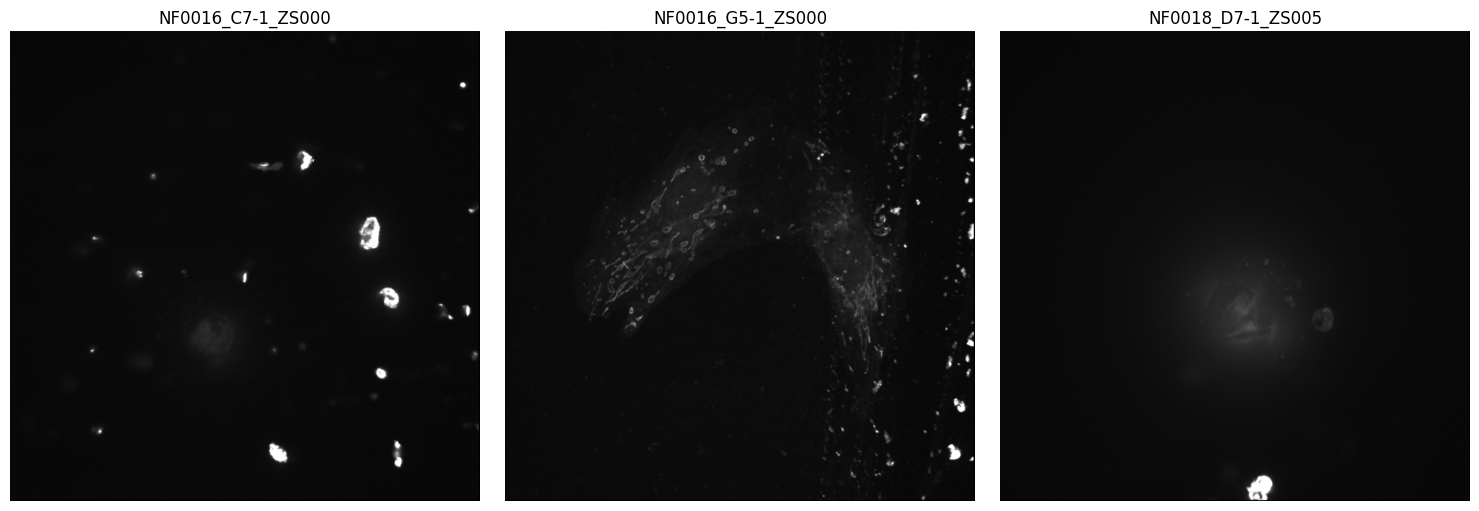

In [8]:
# Combine PathName and FileName columns to construct full paths for Mito
saturation_Mito_outliers["Full_Path_Mito"] = (
    saturation_Mito_outliers["PathName_Mito"] + "/" + saturation_Mito_outliers["FileName_Mito"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = saturation_Mito_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"]
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=0)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(selected_images.itertuples(), start=1):
    image_path = row.Full_Path_Mito
    # Format the metadata title based on your desired structure
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)  # Set the formatted metadata as the title
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# Read the content of the pipeline file
with open(pipeline_path, 'r') as file:
    pipeline_content = file.read()

# Find the minimum value of the ImageQuality_PercentMaximal_Mito from the outliers dataframe
min_value_mito = saturation_Mito_outliers['ImageQuality_PercentMaximal_Mito'].min()

# Define the regex pattern to find the relevant section and update the Maximum value with min value (anything above this value will be flagged)
pattern = re.compile(
    r'(Which measurement\?:ImageQuality_PercentMaximal_Mito.*?Maximum value:\s*)-?\d+(\.\d+)?',
    re.DOTALL
)

# Update the pipeline content
updated_pipeline_content = pattern.sub(lambda m: f"{m.group(1)}{min_value_mito}", pipeline_content)

# Write the updated content back to the file
with open(pipeline_path, 'w') as file:
    file.write(updated_pipeline_content)

print(f"Updated the Maximum value for ImageQuality_PercentMaximal_Mito to {min_value_mito} in the template pipeline file.")

Updated the Maximum value for ImageQuality_PercentMaximal_Mito to 0.0897023704041247 in the template pipeline file.


## Detect over-saturation in ER channel

In [10]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for the ER channel
saturation_er_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_ER": 2,
    },
)

pd.DataFrame(saturation_er_outliers).head()

Number of outliers: 1 (0.01%)
Outliers Range:
ImageQuality_PercentMaximal_ER Min: 100.0
ImageQuality_PercentMaximal_ER Max: 100.0


,ImageQuality_PercentMaximal_ER,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito
8408,100.0,E9-1_555_ZS000_FOV-1.tif,E9-1_TRANS_ZS000_FOV-1.tif,E9-1_405_ZS000_FOV-1.tif,E9-1_488_ZS000_FOV-1.tif,E9-1_640_ZS000_FOV-1.tif,NaN,NaN,0,NF0014,0,1.0,E9,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...


1


/tmp/ipykernel_2899703/1193546265.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))


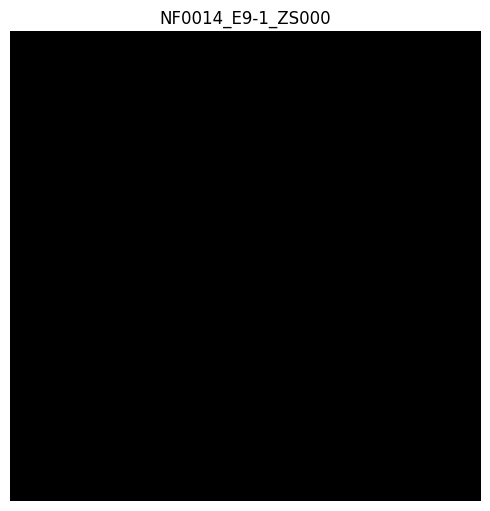

In [11]:
# Combine PathName and FileName columns to construct full paths
saturation_er_outliers["Full_Path_ER"] = (
    saturation_er_outliers["PathName_ER"] + "/" + saturation_er_outliers["FileName_ER"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = saturation_er_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"],
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 1 unique images
if len(unique_samples) < 1:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=1, random_state=0)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_ER
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# Read the content of the pipeline file
with open(pipeline_path, 'r') as file:
    pipeline_content = file.read()

# Find the minimum value of the ImageQuality_PercentMaximal_ER from the outliers dataframe
min_value_er = saturation_er_outliers['ImageQuality_PercentMaximal_ER'].min()

# Define the regex pattern to find the relevant section and update the Maximum value with min value (anything above this value will be flagged)
pattern = re.compile(
    r'(Which measurement\?:ImageQuality_PercentMaximal_ER.*?Maximum value:\s*)-?\d+(\.\d+)?',
    re.DOTALL
)

# Update the pipeline content
updated_pipeline_content = pattern.sub(lambda m: f"{m.group(1)}{min_value_er}", pipeline_content)

# Write the updated content back to the file
with open(pipeline_path, 'w') as file:
    file.write(updated_pipeline_content)

print(f"Updated the Maximum value for ImageQuality_PercentMaximal_ER to {min_value_er} in the template pipeline file.")

Updated the Maximum value for ImageQuality_PercentMaximal_ER to 100.0 in the template pipeline file.


## Detect over-saturation in AGP channel

In [13]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for AGP channel
saturation_agp_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_AGP": 4,
    },
)

pd.DataFrame(saturation_agp_outliers).head()

Number of outliers: 9 (0.09%)
Outliers Range:
ImageQuality_PercentMaximal_AGP Min: 0.0059147098834802
ImageQuality_PercentMaximal_AGP Max: 0.1062842290912466


,ImageQuality_PercentMaximal_AGP,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito
887,0.007173,D3-2 (60X)_555_ZS010_FOV-1.tif,D3-2 (60X)_TRANS_ZS010_FOV-1.tif,D3-2 (60X)_405_ZS010_FOV-1.tif,D3-2 (60X)_488_ZS010_FOV-1.tif,D3-2 (60X)_640_ZS010_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D3,ZS010,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
890,0.106284,D3-2 (60X)_555_ZS013_FOV-1.tif,D3-2 (60X)_TRANS_ZS013_FOV-1.tif,D3-2 (60X)_405_ZS013_FOV-1.tif,D3-2 (60X)_488_ZS013_FOV-1.tif,D3-2 (60X)_640_ZS013_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D3,ZS013,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
2300,0.006329,F10-2 (60X)_555_ZS015_FOV-1.tif,F10-2 (60X)_TRANS_ZS015_FOV-1.tif,F10-2 (60X)_405_ZS015_FOV-1.tif,F10-2 (60X)_488_ZS015_FOV-1.tif,F10-2 (60X)_640_ZS015_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,F10,ZS015,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
2301,0.009578,F10-2 (60X)_555_ZS016_FOV-1.tif,F10-2 (60X)_TRANS_ZS016_FOV-1.tif,F10-2 (60X)_405_ZS016_FOV-1.tif,F10-2 (60X)_488_ZS016_FOV-1.tif,F10-2 (60X)_640_ZS016_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,F10,ZS016,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
2302,0.008861,F10-2 (60X)_555_ZS017_FOV-1.tif,F10-2 (60X)_TRANS_ZS017_FOV-1.tif,F10-2 (60X)_405_ZS017_FOV-1.tif,F10-2 (60X)_488_ZS017_FOV-1.tif,F10-2 (60X)_640_ZS017_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,F10,ZS017,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...


6


/tmp/ipykernel_2899703/1087590450.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=None))


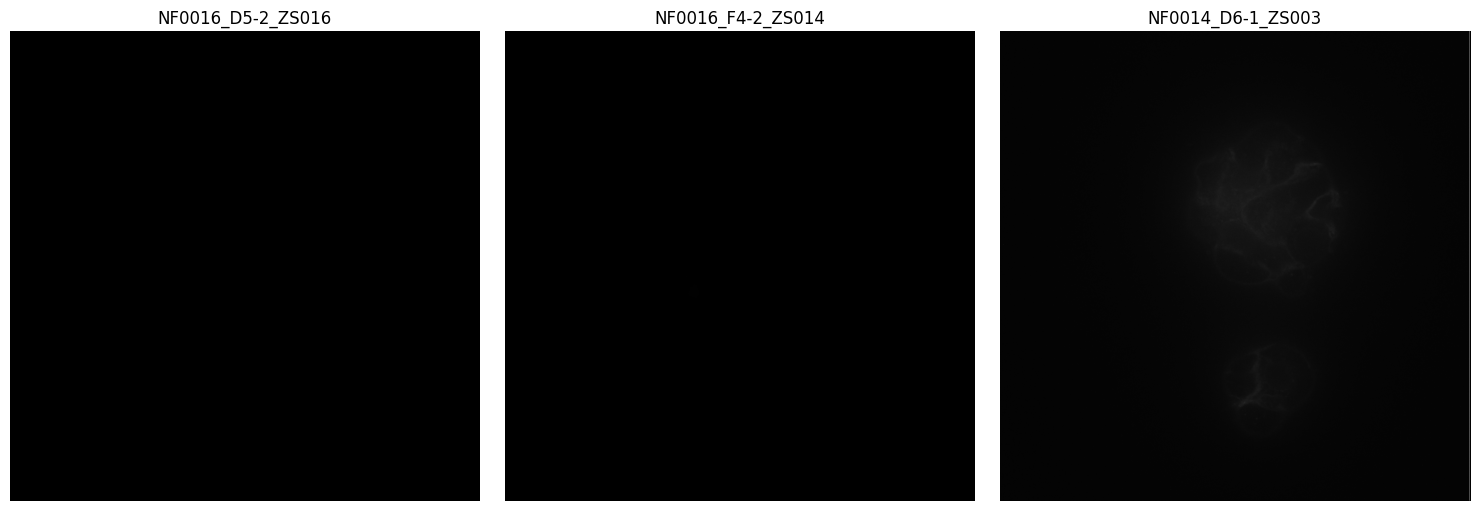

In [14]:
# Combine PathName and FileName columns to construct full paths
saturation_agp_outliers["Full_Path_AGP"] = (
    saturation_agp_outliers["PathName_AGP"] + "/" + saturation_agp_outliers["FileName_AGP"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = saturation_agp_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"],
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=None))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=None)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_AGP
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
# Read the content of the pipeline file
with open(pipeline_path, 'r') as file:
    pipeline_content = file.read()

# Find the minimum value of the ImageQuality_PercentMaximal_AGP from the outliers dataframe
min_value_agp = saturation_agp_outliers['ImageQuality_PercentMaximal_AGP'].min()

# Define the regex pattern to find the relevant section and update the Maximum value with min value (anything above this value will be flagged)
pattern = re.compile(
    r'(Which measurement\?:ImageQuality_PercentMaximal_AGP.*?Maximum value:\s*)-?\d+(\.\d+)?',
    re.DOTALL
)

# Update the pipeline content
updated_pipeline_content = pattern.sub(lambda m: f"{m.group(1)}{min_value_agp}", pipeline_content)

# Write the updated content back to the file
with open(pipeline_path, 'w') as file:
    file.write(updated_pipeline_content)

print(f"Updated the Maximum value for ImageQuality_PercentMaximal_AGP to {min_value_agp} in the template pipeline file.")

Updated the Maximum value for ImageQuality_PercentMaximal_AGP to 0.0059147098834802 in the template pipeline file.


## Detect over-saturation in Brightfield channel

In [16]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find outliers for Brightfield channel
saturation_brightfield_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PercentMaximal_Brightfield": 10,
    },
)

pd.DataFrame(saturation_brightfield_outliers).head()

Number of outliers: 13 (0.13%)
Outliers Range:
ImageQuality_PercentMaximal_Brightfield Min: 0.0395770571209167
ImageQuality_PercentMaximal_Brightfield Max: 0.065989890551294


,ImageQuality_PercentMaximal_Brightfield,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito
3871,0.039577,C10-2 (60X)_555_ZS000_FOV-1.tif,C10-2 (60X)_TRANS_ZS000_FOV-1.tif,C10-2 (60X)_405_ZS000_FOV-1.tif,C10-2 (60X)_488_ZS000_FOV-1.tif,C10-2 (60X)_640_ZS000_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,C10,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
3872,0.041855,C10-2 (60X)_555_ZS001_FOV-1.tif,C10-2 (60X)_TRANS_ZS001_FOV-1.tif,C10-2 (60X)_405_ZS001_FOV-1.tif,C10-2 (60X)_488_ZS001_FOV-1.tif,C10-2 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,C10,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
5584,0.052362,F11-3 (60X)_555_ZS015_FOV-1.tif,F11-3 (60X)_TRANS_ZS015_FOV-1.tif,F11-3 (60X)_405_ZS015_FOV-1.tif,F11-3 (60X)_488_ZS015_FOV-1.tif,F11-3 (60X)_640_ZS015_FOV-1.tif,NaN,NaN,0,NF0016,0,3.0,F11,ZS015,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
5585,0.065990,F11-3 (60X)_555_ZS016_FOV-1.tif,F11-3 (60X)_TRANS_ZS016_FOV-1.tif,F11-3 (60X)_405_ZS016_FOV-1.tif,F11-3 (60X)_488_ZS016_FOV-1.tif,F11-3 (60X)_640_ZS016_FOV-1.tif,NaN,NaN,0,NF0016,0,3.0,F11,ZS016,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...
5586,0.065441,F11-3 (60X)_555_ZS017_FOV-1.tif,F11-3 (60X)_TRANS_ZS017_FOV-1.tif,F11-3 (60X)_405_ZS017_FOV-1.tif,F11-3 (60X)_488_ZS017_FOV-1.tif,F11-3 (60X)_640_ZS017_FOV-1.tif,NaN,NaN,0,NF0016,0,3.0,F11,ZS017,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...


3


/tmp/ipykernel_2899703/3739885871.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))


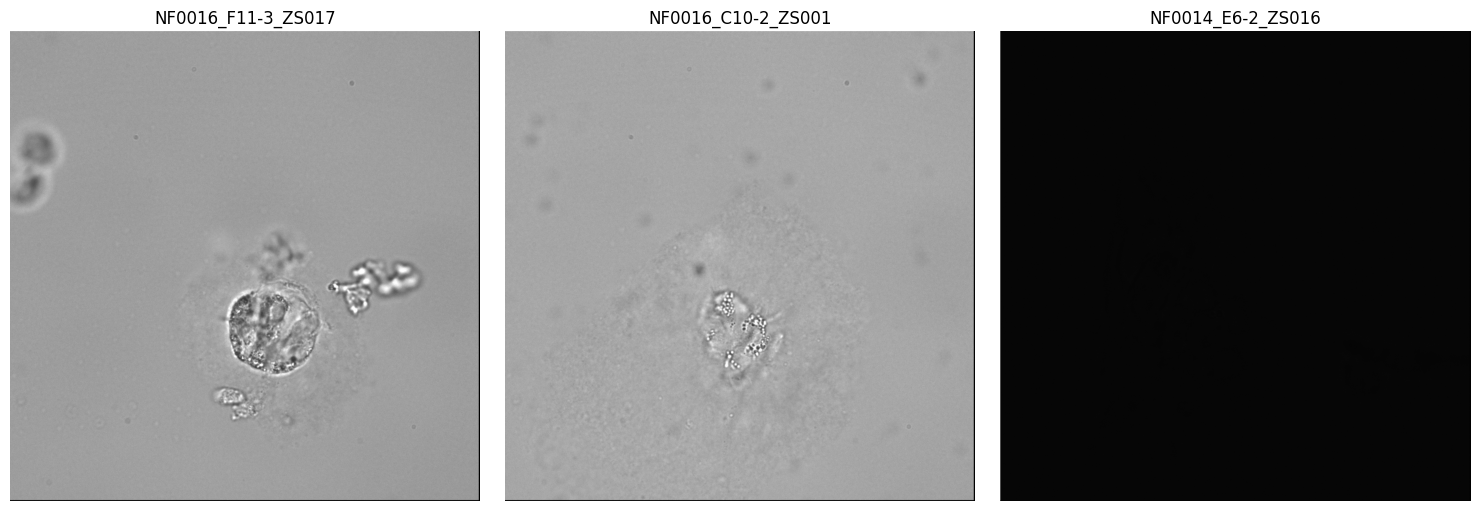

In [17]:
# Combine PathName and FileName columns to construct full paths
saturation_brightfield_outliers["Full_Path_Brightfield"] = (
    saturation_brightfield_outliers["PathName_Brightfield"] + "/" + saturation_brightfield_outliers["FileName_Brightfield"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = saturation_brightfield_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"],
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=0)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_Brightfield
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice}"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
# Read the content of the pipeline file
with open(pipeline_path, 'r') as file:
    pipeline_content = file.read()

# Find the minimum value of the ImageQuality_PercentMaximal_Brightfield from the outliers dataframe
min_value_brightfield = saturation_brightfield_outliers['ImageQuality_PercentMaximal_Brightfield'].min()

# Define the regex pattern to find the relevant section and update the Maximum value with min value (anything above this value will be flagged)
pattern = re.compile(
    r'(Which measurement\?:ImageQuality_PercentMaximal_Brightfield.*?Maximum value:\s*)-?\d+(\.\d+)?',
    re.DOTALL
)

# Update the pipeline content
updated_pipeline_content = pattern.sub(lambda m: f"{m.group(1)}{min_value_brightfield}", pipeline_content)

# Write the updated content back to the file
with open(pipeline_path, 'w') as file:
    file.write(updated_pipeline_content)

print(f"Updated the Maximum value for ImageQuality_PercentMaximal_Brightfield to {min_value_brightfield} in the template pipeline file.")

Updated the Maximum value for ImageQuality_PercentMaximal_Brightfield to 0.0395770571209167 in the template pipeline file.


## Create parquet file with each plate/well/site combos and boolean for pass/fail saturation per channel

In [19]:
# Combine all saturation outliers dataframes into a single dataframe
saturation_outliers = pd.concat(
    [saturation_DNA_outliers, saturation_Mito_outliers, saturation_agp_outliers, saturation_brightfield_outliers, saturation_er_outliers],
    keys=['DNA', 'Mito', 'AGP', 'Brightfield', 'ER'],
    names=['Channel']
).reset_index(level='Channel')

# Create a new dataframe with unique combinations of Metadata_Plate, Metadata_Well, and Metadata_Site
unique_combos = concat_qc_df[['Metadata_Plate', 'Metadata_Well', 'Metadata_Site']].drop_duplicates()

# Initialize columns for each channel with False
for channel in ['DNA', 'Mito', 'AGP', 'Brightfield', 'ER']:
    unique_combos[f'Saturated_{channel}'] = False

# Flag the combos for saturation detection
for channel in ['DNA', 'Mito', 'AGP', 'Brightfield', 'ER']:
    saturation_combos = saturation_outliers[saturation_outliers['Channel'] == channel][['Metadata_Plate', 'Metadata_Well', 'Metadata_Site']].drop_duplicates()
    unique_combos.loc[
        unique_combos.set_index(['Metadata_Plate', 'Metadata_Well', 'Metadata_Site']).index.isin(saturation_combos.set_index(['Metadata_Plate', 'Metadata_Well', 'Metadata_Site']).index),
        f'Saturated_{channel}'
    ] = True

# Reset the index on the unique combos dataframe
unique_combos = unique_combos.reset_index(drop=True)

# Save the unique_combos dataframe to a parquet file
unique_combos.to_parquet(qc_results_dir / "all_plates_saturation_results.parquet")

# Print the number of rows with at least one Saturated column set to True
num_saturated_rows = unique_combos.loc[:, 'Saturated_DNA':'Saturated_ER'].any(axis=1).sum()
print(f"Number of organoids detected as poor quality due to saturation (in any channel): {num_saturated_rows}")

# Calculate and print the percentage of organoids detected as containing saturation
percentage_saturated = (num_saturated_rows / len(unique_combos)) * 100
print(f"Percentage of organoids detected as poor quality due to saturation: {percentage_saturated:.2f}%")

# Display the resulting dataframe
print(unique_combos.shape)
unique_combos.head()

Number of organoids detected as poor quality due to saturation (in any channel): 36
Percentage of organoids detected as poor quality due to saturation: 9.35%
(385, 8)


,Metadata_Plate,Metadata_Well,Metadata_Site,Saturated_DNA,Saturated_Mito,Saturated_AGP,Saturated_Brightfield,Saturated_ER
0,NF0018,C10,1.0,False,False,False,False,False
1,NF0018,C10,2.0,False,False,False,False,False
2,NF0018,C10,3.0,False,False,False,False,False
3,NF0018,C11,1.0,False,False,False,False,False
4,NF0018,C11,2.0,False,False,False,False,False
